## Indonesia's Driving License Data Extraction using Document AI and Python

In this tutorial, we will use Document AI's custom processor to extract Indonesia's Driving License card (SIM). For learning purpose, we use example cards available in Google search.

We will follow this [official documentation](https://cloud.google.com/document-ai/docs/workbench/build-custom-processor) as reference.

#### 1. Prepare Driving License Files (For Training Purpose)

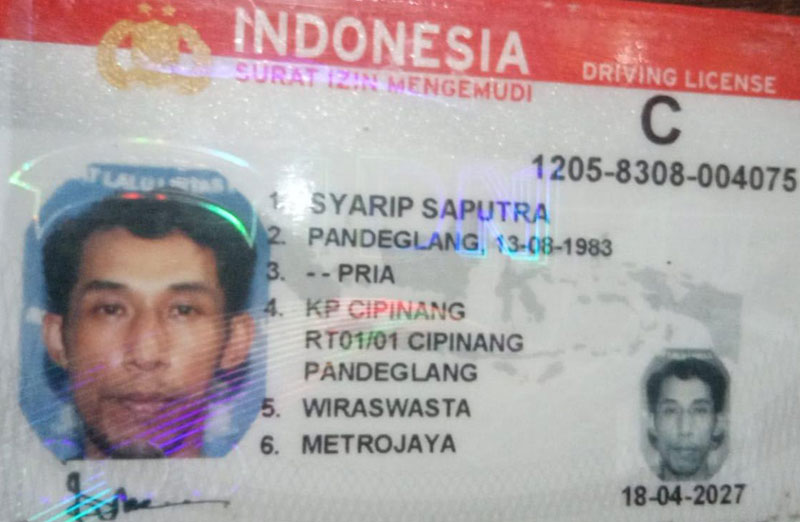

In [1]:
# here is the example of id card
import PIL.Image

img = PIL.Image.open('./examples/Driving License/sim1.jpg')
img

#### 2. Create Custom Processor in Document AI Dashboard

#### 3. Annotate (Label) the Entities

#### 4. Follow Along the Official Documentation Until We Get Processor ID

Click [official documentation](https://cloud.google.com/document-ai/docs/workbench/build-custom-processor)

![image4](../assets/document-ai5.png)

#### 5. Setup Environment 

In [2]:
import os
import json
from google.cloud import documentai_v1 as documentai
from google.oauth2 import service_account
from mimetypes import guess_type
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
project_id = os.environ['PROJECT_ID']
location = os.environ['REGION']
processor_id = os.environ['IDN_DRIVING_LICENSE_PROCESSOR_ID']

In [6]:
service_account_path = '../norse.json' # change this path

In [7]:
credentials = service_account.Credentials.from_service_account_file(service_account_path)   

#### 6. Create Extraction Function

In [8]:
def online_process(
    project_id: str,
    location: str,
    processor_id: str,
    file_path: str,
    file_name: str,
) -> documentai.Document:
    """
    Processes a document using the Document AI Online Processing API.
    """

    opts = {"api_endpoint": f"{location}-documentai.googleapis.com"}

    # Instantiates a client by passing credentials and the API endpoint
    documentai_client = documentai.DocumentProcessorServiceClient(client_options=opts, credentials=credentials)

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    resource_name = documentai_client.processor_path(project_id, location, processor_id)

    # Read the file into memory
    with open(file_path, "rb") as file:
        file_content = file.read()

    # Guess the MIME type based on the file name
    mime_type, _ = guess_type(file_name)
    if mime_type is None:
        raise ValueError("Unable to determine the file's MIME type")

    # Load Binary Data into Document AI RawDocument Object
    raw_document = documentai.RawDocument(content=file_content, mime_type=mime_type)

    # Configure the process request
    request = documentai.ProcessRequest(name=resource_name, raw_document=raw_document)

    # Use the Document AI client to process the sample form
    result = documentai_client.process_document(request=request)

    # Extract entities from the document
    entities = []
    for entity in result.document.entities:
        entities.append({
            "text": entity.mention_text.lower(),
            "type": entity.type_,
            "confidence": entity.confidence
        })

    return {"entities": entities}  # Return the processed entities

#### 7. Run The Extraction

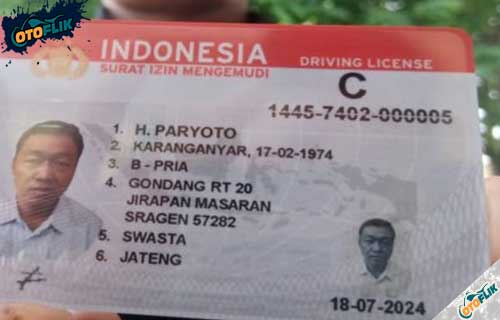

In [9]:
# load example id card
file_path = './examples/Driving License/sim8.jpg'
# Extract file name from file path
file_name = os.path.basename(file_path)

PIL.Image.open(file_path)

In [10]:
response = online_process(project_id, location, processor_id, file_path, file_name)

In [11]:
response['entities']

[{'text': 'karanganyar', 'type': 'birthOfCity', 'confidence': 1.0},
 {'text': '17-02-1974', 'type': 'dateOfBirth', 'confidence': 1.0},
 {'text': 'b', 'type': 'bloodType', 'confidence': 1.0},
 {'text': 'gondang rt 20 jirapan masaran sragen 57282',
  'type': 'address',
  'confidence': 1.0},
 {'text': 'jateng', 'type': 'issuer', 'confidence': 1.0},
 {'text': '1445-7402-000005', 'type': 'licenseNumber', 'confidence': 1.0},
 {'text': '-pria', 'type': 'gender', 'confidence': 0.5},
 {'text': 'h. paryoto', 'type': 'fullName', 'confidence': 1.0},
 {'text': 'c', 'type': 'licenseType', 'confidence': 1.0},
 {'text': '18-07-2024', 'type': 'validUntil', 'confidence': 1.0},
 {'text': 'swasta', 'type': 'occupation', 'confidence': 1.0}]

In [12]:
# show the extracted entities as pandas dataframe
# Extract and display information from the document
import pandas as pd
types = []
raw_values = []
confidence = []

for entity in response['entities']:
    types.append(entity['type'])
    raw_values.append(entity['text'])
    confidence.append(f"{entity['confidence']:.0%}")

df = pd.DataFrame(
    {
        "Type": types,
        "Raw Value": raw_values,
        "Confidence": confidence,
    }
)

df

,Type,Raw Value,Confidence
0,birthOfCity,karanganyar,100%
1,dateOfBirth,17-02-1974,100%
2,bloodType,b,100%
3,address,gondang rt 20 jirapan masaran sragen 57282,100%
4,issuer,jateng,100%
5,licenseNumber,1445-7402-000005,100%
6,gender,-pria,50%
7,fullName,h. paryoto,100%
8,licenseType,c,100%
9,validUntil,18-07-2024,100%
